# Explore linear projection, classification, and regression methods, again on digit recognition and temperature prediction.  

Aims -
1. Become familiar with PCA, Linear Logistic Regression, SVM, and Linear Regression methods. 
2. Gain practice using visualizations and analysis to better understand the models and their effectiveness
3. Gain experience in classification and regression applications


### PCA on MNIST

In [2]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression


def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

#### Part 1: PCA and Data Compression

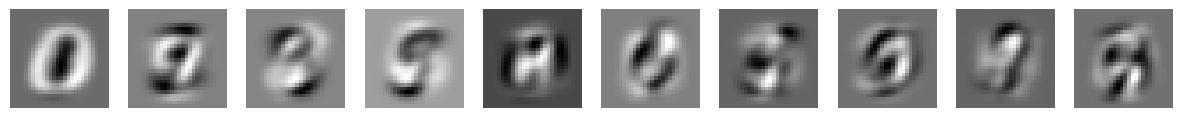

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_mnist()

# Compute the principal components using x_train
model = PCA()
pca = model.fit(x_train)

# Display First 10 Components
display_mnist(pca.components_[:10], 1, 10)

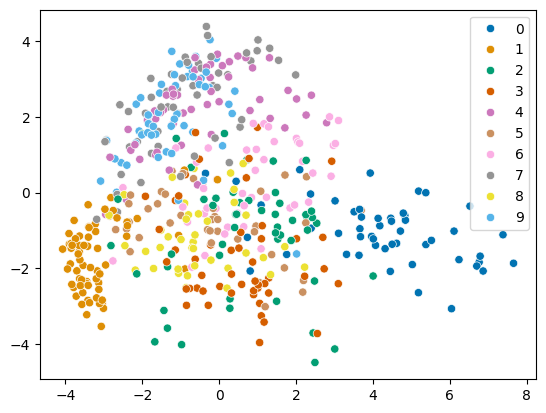

In [ ]:
# Scatter plot of first two PCA dimensions
import seaborn as sns

x_transformed = pca.transform(x_train[:500])
ind = np.arange(500)
sns.scatterplot(x = x_transformed[ind, 0], y = x_transformed[ind, 1], hue = y_train[ind], palette = "colorblind")
plt.show()

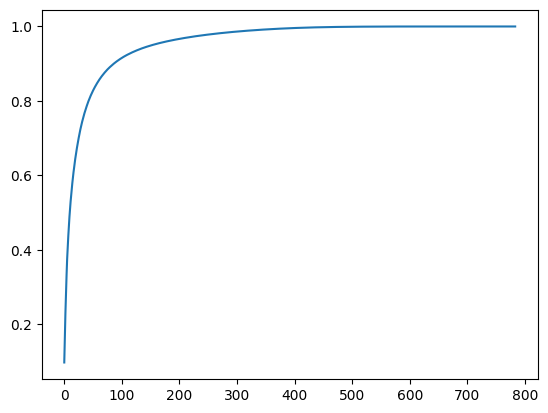

In [ ]:
# Plot cumulative explained variance ratio

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
!apt install libomp-dev > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1

In [ ]:
import faiss
import time

def get_nearest_faiss(X_query, X):
    '''
    Return the index of the sample in X that is closest to X_query and the distance between them, according
    to L2 distance(exact search)
    '''
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X)
    distances, indices = index.search(X_query, 1)

    return indices.flatten(), distances.flatten()

# Select number of dimensions that explains 90% of variance, according to plot above
print(np.sum(pca.explained_variance_ratio_[:86]) * 100)
print(np.sum(pca.explained_variance_ratio_[:87]) * 100) # 1st 87 components explain just over 90% of variance

# model = PCA(87)
# pca = model.fit(x_train)

original_components = pca.components_.copy()  # copy of original principle components
pca.components_[87:] = 0  # setting principle components 88 and onwards to 0 so they don't affect the transform
x_train_compressed = pca.transform(x_train)[:, :87]
x_test_compressed = pca.transform(x_test)[:, :87]
pca.components_ = original_components # restoring components

print(x_train_compressed.shape)

# Get time and error when using original features with brute force 1-NN
start = time.time()
indices = get_nearest_faiss(x_test, x_train)[0]
y_pred = y_train[indices]
end = time.time()

timing_original = end - start
err_original = (np.sum(y_pred != y_test) / y_test.shape[0])


# Get time and error when using compressed features with brute force 1-NN
start = time.time()
indices = get_nearest_faiss(x_test_compressed, x_train_compressed)[0]
y_pred = y_train[indices]
end = time.time()

timing_compressed = end - start
err_compressed = (np.sum(y_pred != y_test) / y_test.shape[0])

print(f'For original features : time = {timing_original}, error = {err_original}')
print(f'For compressed features : time = {timing_compressed}, error = {err_compressed}')

89.88046501416065
90.01062226425088
(60000, 87)
For original features : time = 18.689087629318237, error = 0.0309
For compressed features : time = 4.854581117630005, error = 0.0266


### Part 2: MNIST Classification with Linear Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
(x_train, y_train), (x_test, y_test) = load_mnist()

LLR/SVM vs training size

In [ ]:
# LLR
def LLR(n, max_iter = 10000):
  llr_model = LogisticRegression(max_iter = max_iter)
  llr_model.fit(x_train[:n], y_train[:n])
  # error = 1 - llr_model.score(x_test, y_test)
  # scores  = llr_model.predict_proba(x_test)

  return llr_model


In [ ]:
# SVM
def SVM(n, c = 1.0, max_iter = 10000):
  svm_model = svm.LinearSVC(max_iter = max_iter, C = c)
  svm_model.fit(x_train[:n], y_train[:n])
  # error = 1 - svm_model.score(x_test, y_test)
  # scores = svm_model.decision_function(x_test)

  return svm_model

In [ ]:
llr_models = [LLR(n) for n in [100, 1000, 10000, 60000]]
svm_models = [SVM(n) for n in [100, 1000, 10000, 60000]]

In [ ]:
llr_errors = [((1 - llr_models[i].score(x_test, y_test)) * 100) for i in range(4)]
svm_errors = [((1 - svm_models[i].score(x_test, y_test)) * 100) for i in range(4)]

print(f'Logistic regression errors = {llr_errors}')
print(f'SVM errors = {svm_errors}')

Logistic regression errors = [32.49999999999999, 13.780000000000003, 9.489999999999998, 7.440000000000002]
SVM errors = [32.36, 16.110000000000003, 11.119999999999997, 8.17]


Error visualization

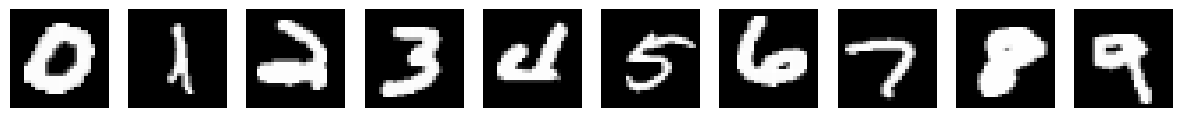

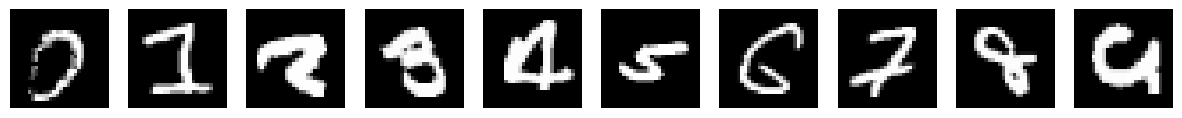

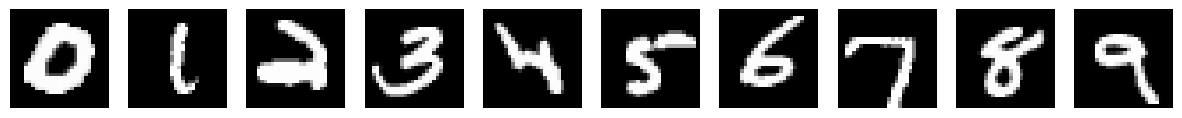

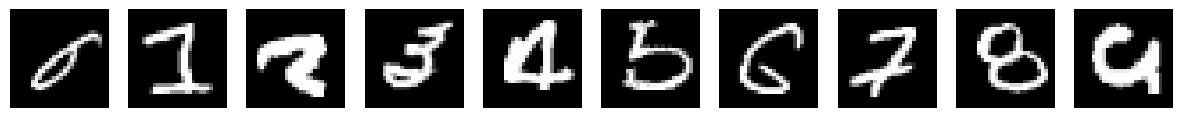

In [ ]:
def visualize_errors(scores):
  '''Displays the most confidently correct and most confidently incorrect test samples for each label
  The confidence is the score of the correct label.  Confidently incorrect means the correct label has a low score.
  Input - Prediction confidence scores for test samples'''
  min_conf_idx = []
  max_conf_idx = []

  for label in range(10):
    label_samples_idx = np.flatnonzero(y_test == label)
    max_conf_idx.append(label_samples_idx[np.argmax(scores[label_samples_idx, label])])
    min_conf_idx.append(label_samples_idx[np.argmin(scores[label_samples_idx, label])])

  display_mnist(x_test[max_conf_idx], 1, 10)
  display_mnist(x_test[min_conf_idx], 1, 10)


# Important error : Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
# scores = llr_models[3].predict_proba(x_test[0,:].reshape(1, -1))
scores = llr_models[3].predict_proba(x_test)
visualize_errors(scores)


scores = svm_models[3].decision_function(x_test)
visualize_errors(scores)

Parameter selection

[12.89 12.58 12.43 12.36 12.35 12.37 12.39 12.53 12.76 13.28 13.83 14.34
 14.98 15.3 ]


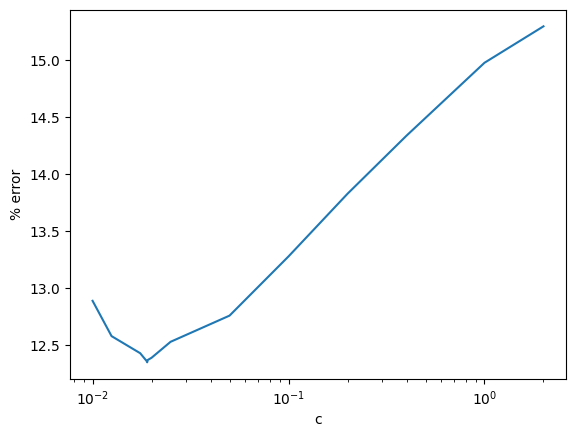

In [ ]:
# Try multiple C parameters, select one that minimizes validation error

# TO DO
errors = []
c_vals = [0.01, 0.0125, 0.0175, 0.0189, 0.0190, 0.0191, 0.0200, 0.0250, 0.05 ,0.1, 0.2, 0.4, 1, 2]
for c in c_vals:
  model = SVM(1000, c)
  accuracy = model.score(x_train[50000:], y_train[50000:])
  errors.append(1 - accuracy)

errors = np.array(errors) * 100
print(errors)

plt.semilogx(c_vals, errors)
plt.ylabel('% error'), plt.xlabel('c')
plt.show()

In [ ]:
# Get test result for selected parameter
model = SVM(1000, 0.019)
accuracy = model.score(x_test, y_test)
error = (1 - accuracy) * 100
print(error)

13.580000000000004


## Part 3: Temperature Regression

Forecasting, predicting a future value based on past values, is a common machine learning problem, which can apply to predicting prices, production, temperature, and many other things. 

The Temperature Regression problem is derived from a Kaggle dataset. The task is to predict the average temperature in Cleveland for the next day given the average temperature of major US cities in the preceding five days.  

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  datadir = "./data"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


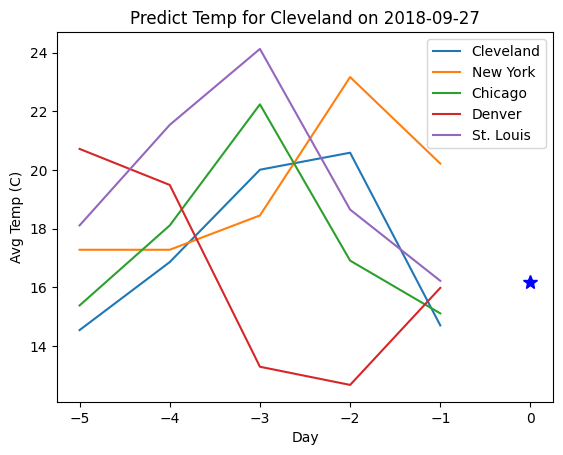

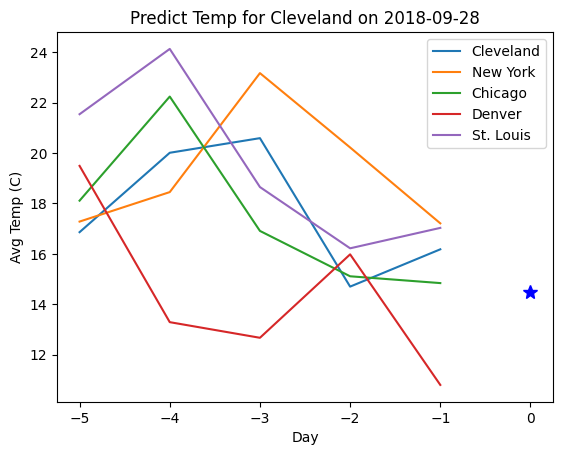

In [ ]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[1], y_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



### Linear regression test

In [ ]:
def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i, fnum]
  return x2, y2

ORIGINAL FEATURES
RMSE = 2.16086


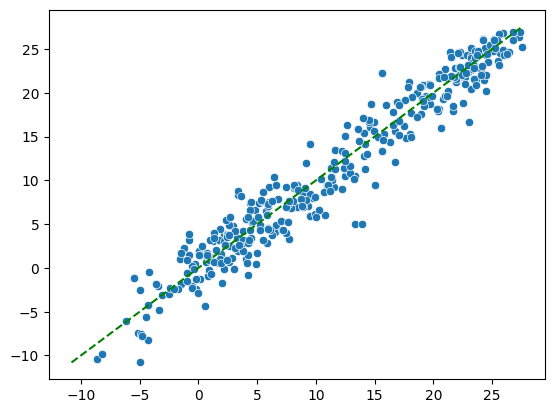


NORMALIZED FEATURES
RMSE = 2.16307


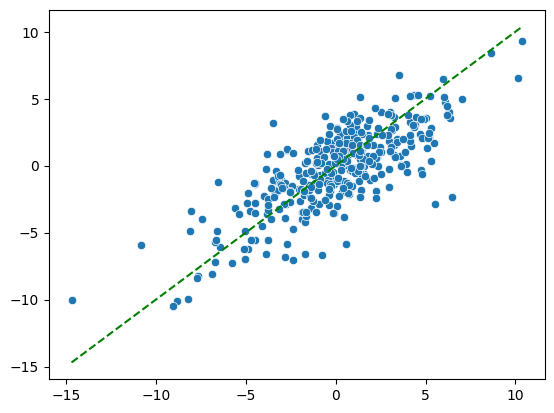

In [ ]:
 # linear regression (use Ridge)
def regress_Ridge(X_train, Y_train, X_test, Y_test):
  model = Ridge()
  model.fit(X_train, Y_train)

  # predict
  y_pred = model.predict(X_test)

  # calculate rmse
  rmse = np.sqrt(np.mean(np.square(y_pred - Y_test)))
  print(f'RMSE = {rmse:.5f}')

  # plot
  plotmin = min(np.min(Y_test), np.min(y_pred))
  plotmax = max(np.max(Y_test), np.max(y_pred))
  plt.figure()
  ax = sns.scatterplot(x = Y_test, y = y_pred)
  ax.plot([plotmin, plotmax], [plotmin, plotmax], '--g')
  plt.show()

# original features
print('ORIGINAL FEATURES')
regress_Ridge(x_train, y_train, x_test, y_test)

# normalized features
print('\nNORMALIZED FEATURES')
fnum = 361 # previous day temp in Cleveland
norm_factor1 = x_train[:,fnum].copy()
norm_factor2 = x_test[:,fnum].copy()
regress_Ridge(x_train - norm_factor1[:, np.newaxis], y_train - norm_factor1, x_test - norm_factor2[:, np.newaxis], y_test - norm_factor2)

# x_train_norm, y_train_norm = normalize_features(x_train, y_train, fnum)
# x_test_norm, y_test_norm = normalize_features(x_test, y_test, fnum)
# y_pred = regress_Ridge(x_train_norm, y_train_norm, x_test_norm, y_test_norm)

### Feature selection

RMSE = 2.19807


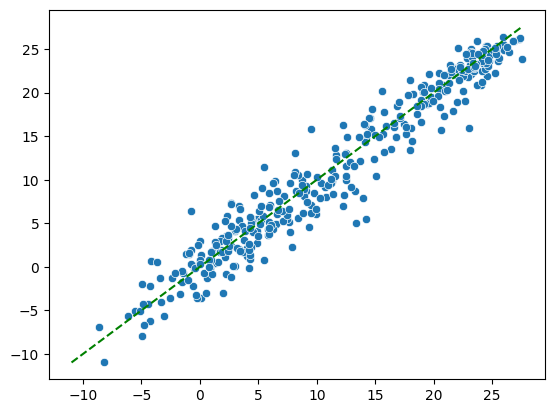


Features that have coefficient magnitudes greater than 0.001 :

 Feature   ||      City       ||    Day     ||        Coeff        
    9      ||     Boston      ||     -5     ||       0.02552       
   175     ||     Boston      ||     -3     ||       0.00540       
   236     ||   Springfield   ||     -3     ||       0.02520       
   264     ||   Minneapolis   ||     -2     ||       -0.04328      
   290     ||   Providence    ||     -2     ||       0.01514       
   307     ||      Omaha      ||     -2     ||       -0.11125      
   334     ||     Chicago     ||     -1     ||       0.27960       
   347     ||   Minneapolis   ||     -1     ||       0.22594       
   354     ||    St. Louis    ||     -1     ||       0.00179       
   361     ||    Cleveland    ||     -1     ||       0.13836       
   366     ||   Kansas City   ||     -1     ||       0.16295       
   367     ||  Indianapolis   ||     -1     ||       0.04610       
   405     ||  Grand Rapids   ||     -1     ||     

In [ ]:
# feature analysis (select important features using Lasso)
model = Lasso()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
rmse = np.sqrt(np.mean(np.square(y_pred - y_test)))
print(f'RMSE = {rmse:.5f}')

# plot
plotmin = min(np.min(y_test), np.min(y_pred))
plotmax = max(np.max(y_test), np.max(y_pred))
plt.figure()
ax = sns.scatterplot(x = y_test, y = y_pred)
ax.plot([plotmin, plotmax], [plotmin, plotmax], '--g')
plt.show()

feature_dict = {}

print('\nFeatures that have coefficient magnitudes greater than 0.001 :')
print(f'\n{"Feature":^10} || {"City":^15} || {"Day":^10} || {"Coeff":^20}')
for i in range(x_train.shape[1]):
  if abs(model.coef_[i]) > 0.001 :
    print(f'{i:^10} || {feature_to_city[i]:^15} || {feature_to_day[i]:^10} || {model.coef_[i]:^20.5f}')
    feature_dict[i] = {'city': feature_to_city[i], 'day' : feature_to_day[i], 'coef' : model.coef_[i]}

sorted_features = sorted(feature_dict, key = lambda x: abs(feature_dict[x]['coef']), reverse = True)

print('\nTop 10 features :')
print(f'\n{"Feature":^10} || {"City":^15} || {"Day":^10} || {"Coeff":^20}')
for feature in sorted_features[:10]:
  print(f"{feature:^10} || {feature_dict[feature]['city']:^15} || {feature_dict[feature]['day']:^10} || {feature_dict[feature]['coef']:^20.5f}")


# predict using best features
model = Ridge()
model.fit(x_train[:,sorted_features[:10]], y_train)
y_pred = model.predict(x_test[:,sorted_features[:10]])
rmse = np.sqrt(np.mean(np.square(y_pred - y_test)))
print('\nRidge regression using top 10 features :')
print(f'RMSE = {rmse:.5f}')

## Part 4: Stretch Goals


a) PR and ROC curves




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

(x_train, y_train), (x_test, y_test) = load_mnist()

# 1 means class is 0 and 0 means its not 0
y_train = np.where(y_train == 0, 1, 0)
y_test = np.where(y_test == 0, 1, 0)

llr_model = LogisticRegression(max_iter = 10000)
llr_model.fit(x_train, y_train)

scores = llr_model.predict_proba(x_test)
pred = llr_model.predict(x_test)
# probabilities for the positive outcome i.e. class being 0
positive_class_scores = scores[:, 1]

AP = 0.9893199594401588


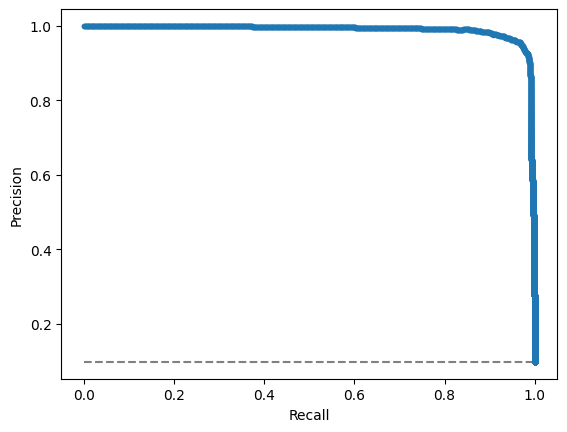

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, positive_class_scores)
AUC = auc(recall, precision)
AP = average_precision_score(y_test, positive_class_scores)

print(f'AP = {AP}')

# the baseline of precision-recall curve is determined by the ratio of positives (P) and negatives (N) as y = P / (P + N). For instance, we have y = 0.5 for a balanced class distribution …
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray')
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

AUC = 0.9983839766505271


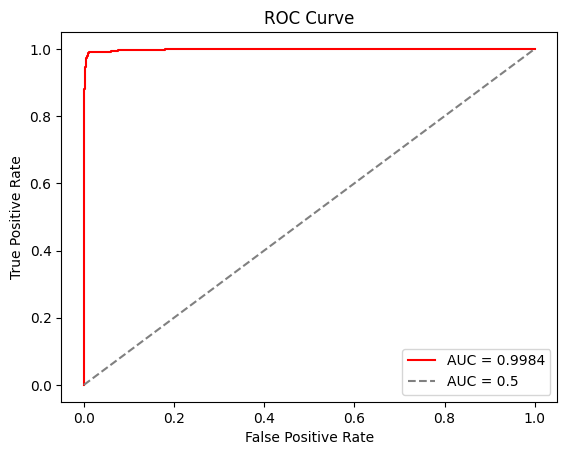

In [ ]:
fpr, tpr, _ = roc_curve(y_test, positive_class_scores)
AUC = auc(fpr, tpr)
print(f'AUC = {AUC}')

plt.figure()
plt.plot(fpr, tpr, color='r', label = f'AUC = {AUC:.4f}') # trained classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label = f'AUC = 0.5') # baseline classifer
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

b) Visualize weights

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

(x_train, y_train), (x_test, y_test) = load_mnist()
n = 1000
l1_model = LogisticRegression(max_iter = 10000, penalty = 'l1', solver = 'saga').fit(x_train[:n], y_train[:n])
l2_model = LogisticRegression(max_iter = 10000, penalty = 'l2', solver = 'saga').fit(x_train[:n], y_train[:n])
elastic_model = LogisticRegression(max_iter = 10000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5).fit(x_train[:n], y_train[:n])
svm_model = svm.LinearSVC(max_iter = 10000).fit(x_train[:n], y_train[:n])

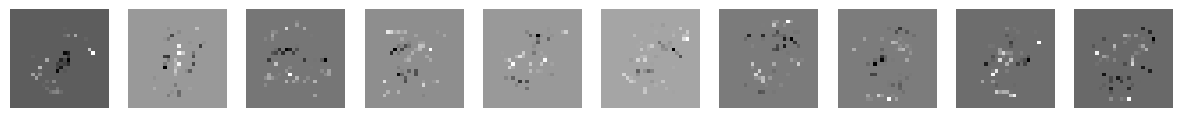

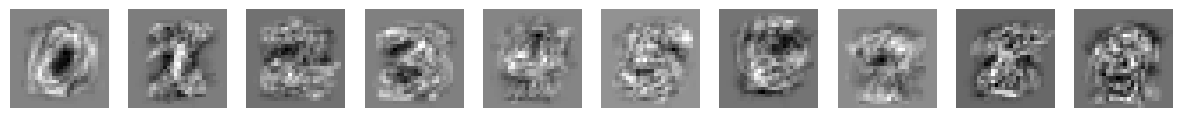

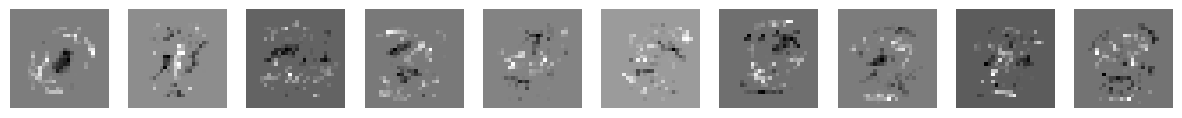

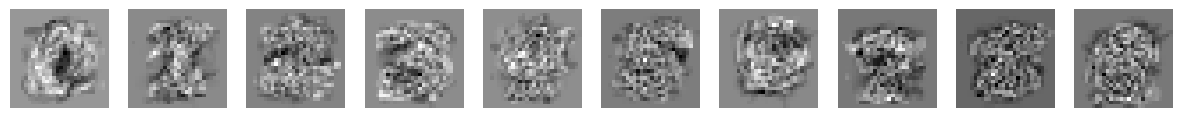

In [ ]:
display_mnist(l1_model.coef_, 1, 10)
display_mnist(l2_model.coef_, 1, 10)
display_mnist(elastic_model.coef_, 1, 10)
display_mnist(svm_model.coef_, 1, 10)

c) Other embeddings

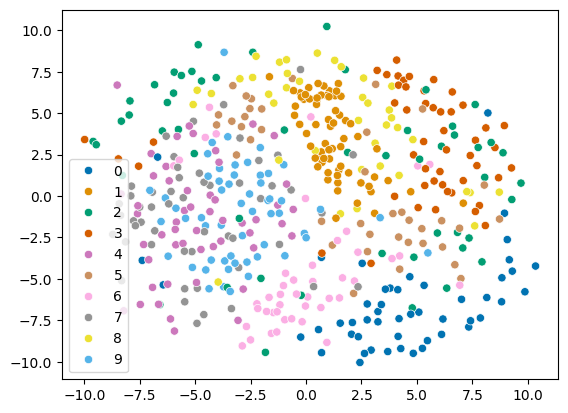

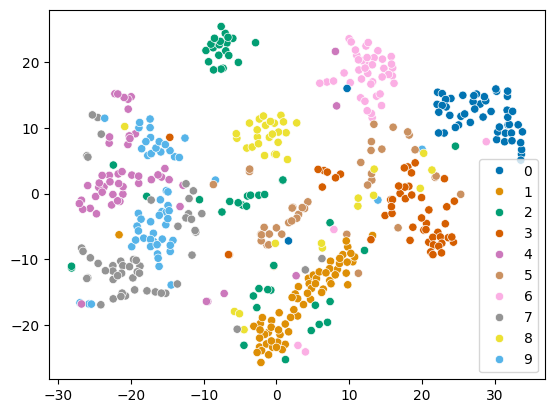

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
(x_train, y_train), (x_test, y_test) = load_mnist()

ind = np.arange(500)

# x_pca = PCA().fit_transform(x_train[:500])
# sns.scatterplot(x = x_pca[ind, 0],y = x_pca[ind, 1], hue = y_train[ind], palette = "colorblind")
# plt.show()

x_mds = MDS(n_components=2, normalized_stress='auto').fit_transform(x_train[:500])
sns.scatterplot(x = x_mds[ind, 0],y = x_mds[ind, 1], hue = y_train[ind], palette = "colorblind")
plt.show()

x_tsne = TSNE(n_components=2).fit_transform(x_train[:500])
sns.scatterplot(x = x_tsne[ind, 0],y = x_tsne[ind, 1], hue = y_train[ind], palette = "colorblind")
plt.show()

d) One city is all you need?

In 3b we saw that

In [ ]:
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

model = Lasso()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
rmse = np.sqrt(np.mean(np.square(y_pred - y_val)))
print(f'RMSE = {rmse:.5f}')

feature_dict = {}
print(f'\n{"Feature":^10} || {"City":^15} || {"Day":^10} || {"Coeff":^20}')
for i in range(x_train.shape[1]):
  if abs(model.coef_[i]) > 0.001 :
    print(f'{i:^10} || {feature_to_city[i]:^15} || {feature_to_day[i]:^10} || {model.coef_[i]:^20.5f}')
    feature_dict[i] = {'city': feature_to_city[i], 'day' : feature_to_day[i], 'coef' : model.coef_[i]}

sorted_features = sorted(feature_dict, key = lambda x: abs(feature_dict[x]['coef']), reverse = True)

coef_sums = {}
for city in feature_to_city[:83]:
  idx = np.where(feature_to_city == city)[0]
  coef_sums[city] = np.sum(abs(model.coef_[idx]))

sorted_coef_sums = {k: coef_sums[k] for k in sorted(coef_sums, key=coef_sums.get, reverse=True)}
print('\n', sorted_coef_sums)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RMSE = 2.38951

 Feature   ||      City       ||    Day     ||        Coeff        
    9      ||     Boston      ||     -5     ||       0.02552       
   175     ||     Boston      ||     -3     ||       0.00540       
   236     ||   Springfield   ||     -3     ||       0.02520       
   264     ||   Minneapolis   ||     -2     ||       -0.04328      
   290     ||   Providence    ||     -2     ||       0.01514       
   307     ||      Omaha      ||     -2     ||       -0.11125      
   334     ||     Chicago     ||     -1     ||       0.27960       
   347     ||   Minneapolis   ||     -1     ||       0.22594       
   354     ||    St. Louis    ||     -1     ||       0.00179       
   361     ||    Cleveland    ||     -1     ||       0.13836       
   366     ||   Kansas City   ||     -1     ||       0.16295       
   367     ||  Indianapolis   ||     -1

Linear regression using L1-regularization will give us coefficients/weights such that important features have high magnitudes weights and less important features have almost 0 weight.

Above (from 3b) we got the features that have an absolute weight greater than 0.001, meaning that they are important to our model.

We can now use the previous 5 day temperatures for the cities that correspond to these important features to find the city that gives the best prediction on its own, when using the validation set.

There are 11 distinct cities - 'Indianapolis', 'Kansas City', 'Omaha', 'Boston', 'Chicago', 'St. Louis', 'Minneapolis', 'Cleveland', 'Springfield', 'Providence', 'Grand Rapids'

The city giving the best RMSE can then be selected and used in testing.


In [ ]:
best_cities = set([inner_dict['city'] for key, inner_dict in feature_dict.items()])

city_preds = {}
for city in best_cities:
  x_train_city = x_train[:, np.where(feature_to_city == city)[0]]
  x_val_city = x_val[:, np.where(feature_to_city == city)[0]]

  y_pred = Ridge().fit(x_train_city, y_train).predict(x_val_city)
  rmse = np.sqrt(np.mean(np.square(y_pred - y_val)))
  city_preds[city] = rmse

sorted_city_preds = {k: city_preds[k] for k in sorted(city_preds, key = city_preds.get)}

for city, rmse in sorted_city_preds.items():
  print(f'{city:15} {rmse}')

St. Louis       2.7256147389643646
Chicago         2.765123380844954
Indianapolis    2.7722098414166583
Grand Rapids    3.0191370390174397
Kansas City     3.2232928659385043
Cleveland       3.2600381077016998
Minneapolis     3.6177793172422192
Omaha           3.8370975983128375
Springfield     4.268485592354153
Providence      4.3678249835061465
Boston          4.375546831804006


In [ ]:
best_city = 'St. Louis'
x_train_city = x_train[:, np.where(feature_to_city == best_city)[0]]
x_test_city = x_test[:, np.where(feature_to_city == best_city)[0]]

y_pred = Ridge().fit(x_train_city, y_train).predict(x_test_city)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(rmse)

3.1263272970544804


e) SVM with RBF Kernel

In [ ]:
from sklearn import svm
(x_train, y_train), (x_test, y_test) = load_mnist()

errors = []
for n in [100, 1000, 10000, 60000]:
  model = svm.SVC().fit(x_train[:n], y_train[:n])
  errors.append(1 - model.score(x_test, y_test))

print(np.array(errors) * 100)

[34.41  9.17  4.06  2.08]
